In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

In [2]:
# hyperparameters

batch_size = 64
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5

In [3]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.RandomCrop(28, 1),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.1307,), (0.3081,))
              #torchvision.transforms.RandomRotation(20)
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 4, 3, padding=1, bias=False),
            nn.BatchNorm2d(4), 
            nn.ReLU(True),
            
            nn.Conv2d(4, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            
            nn.Conv2d(8, 2, 7, bias=False), # N, 2, 1, 1
            nn.BatchNorm2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 7, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 4, 3, padding=1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(4, 1, 3, padding=1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        #print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder_conv().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model

Autoencoder_conv(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(8, 2, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (7): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 8, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    for (img, _) in dataloader:
        img = img.to(device)
        recon = model(img)
        loss = loss_fn(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    return (epoch, img, recon)


In [7]:
epochs = 8
outputs = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    output = train(train_dataloader, model, loss_fn, optimizer)
    outputs.append(output)
print("Finished")

Epoch 1
-------------------------------
Epoch:1, Loss:0.4708
Epoch 2
-------------------------------
Epoch:2, Loss:0.4633
Epoch 3
-------------------------------
Epoch:3, Loss:0.4476
Epoch 4
-------------------------------
Epoch:4, Loss:0.4653
Epoch 5
-------------------------------
Epoch:5, Loss:0.4785
Epoch 6
-------------------------------
Epoch:6, Loss:0.4507
Epoch 7
-------------------------------
Epoch:7, Loss:0.4261
Epoch 8
-------------------------------
Epoch:8, Loss:0.4569
Finished


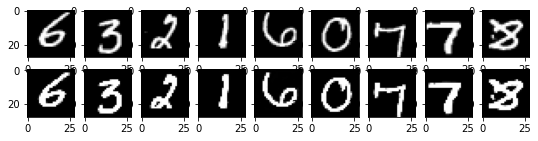

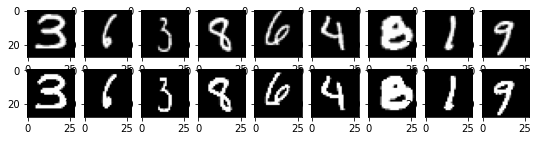

In [8]:
for k in range(0, epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])